The codes used to build data in this study are in `src/datas/build_data.py`. This notebook is to investigate our data, make sure it is correct and identical to the baseline ([Lee et al., 2022](https://doi.org/10.1038/s41598-022-25377-x)).

In [57]:
import pandas as pd
import numpy as np
import glob
from src.utils import nwp_cali
import matplotlib.pyplot as plt

import os
cwd = os.getcwd()

# get today's date
from datetime import date
today = date.today()
date = today.strftime("%Y%m%d")
print("Today's date:", date)

Today's date: 20240716


# XRF spectra

The spectra are extracted from `data/legacy/spe_dataset_20220629.csv`. We selected three cores (PS75-056-1, LV28-44-3-n, SO264-69-2) as the test set, which is relevant to the case study in the baseline. The baseline's method describes these three cores as the case study, but the core PS75-056-1 was accidently excluded in the actual calculation of R2 and data distribution. Yet, the confident interval of the baseline models were calcuated by the whole three cores. It is a mistake needs to be corrected. This study keeps the three cores as the test set for all calculation. Then we use the rest of the cores as the training set, which are later randomly split into the (actual) training and validation sets with 4:1 ratio.

## Test set

In [2]:
test_df = pd.read_csv(f"{cwd}/data/pretrain/test/info.csv")
spe_dir = glob.glob(f"{cwd}/data/pretrain/test/spe/*.csv")
test_df

,dirname,composite_id,cps,core,composite_depth_mm,section_depth_mm,filename,section
0,0.csv,PS75-056-1_00005,126814,PS75-056-1,5,5,PS75-056-1_0000 5.0mm 10s 10kV 150uA No-F...,0
1,1.csv,PS75-056-1_00010,170569,PS75-056-1,10,10,PS75-056-1_0000 10.0mm 10s 10kV 150uA No-F...,0
2,2.csv,PS75-056-1_00015,175200,PS75-056-1,15,15,PS75-056-1_0000 15.0mm 10s 10kV 150uA No-F...,0
3,3.csv,PS75-056-1_00020,175607,PS75-056-1,20,20,PS75-056-1_0000 20.0mm 10s 10kV 150uA No-F...,0
4,4.csv,PS75-056-1_00025,176768,PS75-056-1,25,25,PS75-056-1_0000 25.0mm 10s 10kV 150uA No-F...,0
...,...,...,...,...,...,...,...,...
4612,4612.csv,SO264-69-2_18460,109462,SO264-69-2,18460,910,SO264-69-1_017550 910.0mm 10s 10kV 150uA No...,18
4613,4613.csv,SO264-69-2_18470,108611,SO264-69-2,18470,920,SO264-69-1_017550 920.0mm 10s 10kV 150uA No...,18
4614,4614.csv,SO264-69-2_18480,111142,SO264-69-2,18480,930,SO264-69-1_017550 930.0mm 10s 10kV 150uA No...,18
4615,4615.csv,SO264-69-2_18490,109224,SO264-69-2,18490,940,SO264-69-1_017550 940.0mm 10s 10kV 150uA No...,18


In [3]:
print(f"data amount: {len(test_df)}")
print(f"spe amount: {len(spe_dir)}")
print(f"cores: {test_df.core.unique()}")

data amount: 4617
spe amount: 4617
cores: ['PS75-056-1' 'LV28-44-3-n' 'SO264-69-2']


## Training and validation sets
The annotation files under the `train` folder are `info.csv` and `val.csv` for the training and validation sets, respectively. The spectra are all stored in `spe` folder, which will be read by the model according to the annotation files.

In [4]:
train_df = pd.read_csv(f"{cwd}/data/pretrain/train/info.csv")
validation_df = pd.read_csv(f"{cwd}/data/pretrain/train/val.csv")
spe_dir = glob.glob(f"{cwd}/data/pretrain/train/spe/*.csv")
train_df

,dirname,composite_id,cps,core,composite_depth_mm,section_depth_mm,filename,section
0,26791.csv,SO264-56-2_04290,127209,SO264-56-2,4290,630,SO264-56-2_03660 630.0mm 10s 10kV 150uA No-...,4
1,46603.csv,PS97-083-2_01610,95705,PS97-083-2,1610,510,PS97-083-2_0110 510.0mm 10s 10kV 150uA No-F...,2
2,5680.csv,SO264-15-2_11600,182204,SO264-15-2,11600,120,SO264-15-2_1148 120.0mm 10s 10kV 150uA No-F...,11
3,30871.csv,SO264-64-1_07700,95539,SO264-64-1,7700,180,SO264-64-1_07520 180.0mm 10s 10kV 150uA No-...,8
4,12141.csv,SO264-26-2_02740,126230,SO264-26-2,2740,320,SO264-26-2_02420 320.0mm 10s 10kV 150uA No-...,3
...,...,...,...,...,...,...,...,...
44163,45866.csv,PS97-079-2_04420,112195,PS97-079-2,4420,140,PS97-79-2_0428 140.0mm 10s 10kV 150uA No-Fi...,3
44164,46782.csv,PS97-083-2_03400,94120,PS97-083-2,3400,320,PS97-083-2_0308 320.0mm 10s 10kV 150uA No-F...,4
44165,1137.csv,SO264-09-2_11390,168316,SO264-09-2,11390,700,SO264-09-2_1069 700.0mm 10s 10kV 150uA No-F...,11
44166,12950.csv,SO264-26-2_10850,154762,SO264-26-2,10850,410,SO264-26-02_10440 410.0mm 10s 10kV 150uA No...,11


In [5]:
cores = np.hstack([train_df.core.unique(), validation_df.core.unique()])

print("train and validation sets")
print(f"data amount: {len(train_df)+len(validation_df)}")
print(f"spe amount: {len(spe_dir)}")

print(f"core amount: {len(cores)}")
print(f"cores: {cores}")

train and validation sets
data amount: 55211
spe amount: 55211
core amount: 116
cores: ['SO264-56-2' 'PS97-083-2' 'SO264-15-2' 'SO264-64-1' 'SO264-26-2'
 'SO178-12-3' 'SO264-62-2' 'SO264-14-1' 'SO264-45-2' 'SO264-47-2'
 'PS75-093-1' 'SO264-32-2' 'SO264-55-1' 'PS97-085-3' 'PS97-093-2'
 'PS97-079-2' 'SO264-28-2' 'LV28-44-3' 'SO264-51-2' 'SO264-44-3'
 'SO264-13-2' 'SO264-22-2' 'PS97-089-1' 'PS75-054-1' 'SO264-41-2'
 'SO264-19-2' 'SO264-16-2' 'SO264-24-3' 'SO264-60-12' 'SO264-09-2'
 'PS97-084-1' 'PS75-095-5' 'PS97-092-1' 'SO264-52-2' 'LV29-114-3'
 'PS75-083-1' 'SO264-70-1' 'PS97-085-3_TC' 'SO264-66-2' 'SO264-53-2'
 'SO264-44-2' 'SO264-54-2' 'PS97-027-2' 'SO264-76-1' 'SO264-46-5'
 'SO264-49-2' 'PS97-084-1_TC' 'SO264-34-2' 'SO202-37-2_re' 'PS97-089-1_TC'
 'PS97-080-1' 'PS97-128-2' 'PS97-078-1' 'PS97-052-4' 'PS97-053-2'
 'PS97-046-4' 'PS75-093-1_TC' 'PS75-083-1_TC' 'SO264-76-1' 'SO264-54-2'
 'PS97-052-4' 'SO264-19-2' 'SO178-12-3' 'SO264-14-1' 'SO264-64-1'
 'SO264-55-1' 'SO264-56-2' 'LV28-44-3

# Downstream tasks
The tasks are predicting CaCO3 and TOC content from XRF spectra. The test set uses the same test cores as the XRF spectra, which is relevent to the case study in the baseline. The paired XRF and targets are extracted from `data/legacy/spe+bulk_dataset_20220629.csv`.The training and validation sets use the cores listed in the "CHOSEN" sheet in `data/legacy/ML station list.xlsx`, instead of the whole rest cores. This is the same as the training and test sets in the baseline. The data from these cores are then randomly split into training and validation sets with 4:1 ratio. 

In [5]:
def read_files(target, subset):
    info_df = pd.read_csv(f"{cwd}/data/finetune/{target}/{subset}/info.csv")
    target_dir = glob.glob(f"{cwd}/data/finetune/{target}/{subset}/target/*.csv")
    spe_dir = glob.glob(f"{cwd}/data/finetune/{target}/{subset}/spe/*.csv")

    print(info_df)
    
    if subset == "test":
        return info_df, target_dir, spe_dir
    else:
        validation_df = pd.read_csv(f"{cwd}/data/finetune/{target}/{subset}/val.csv")
        return info_df, validation_df, target_dir, spe_dir

## CaCO3
### Test set

In [6]:
target = "CaCO3%"
subset = "test"
info_df, target_dir, spe_dir = read_files(target, subset)

     dirname         core  mid_depth_mm
0      0.csv   PS75-056-1          15.0
1      1.csv   PS75-056-1          55.0
2      2.csv   PS75-056-1         155.0
3      3.csv   PS75-056-1         255.0
4      4.csv   PS75-056-1         355.0
..       ...          ...           ...
389  389.csv  LV28-44-3-n       10875.0
390  390.csv  LV28-44-3-n       10925.0
391  391.csv  LV28-44-3-n       10975.0
392  392.csv  LV28-44-3-n       11025.0
393  393.csv  LV28-44-3-n       11075.0

[394 rows x 3 columns]


In [7]:
# use the baseline codes to subset data
test_cores = ["PS75-056-1", "LV28-44-3-n", "SO264-69-2"]
prepare = nwp_cali.PrepareData(
    measurement=target, 
    data_dir=f"{cwd}/data/legacy/spe+bulk_dataset_20220629.csv", 
    select_dir=f"{cwd}/data/legacy/ML station list.xlsx")

# note: its select_casestudy()
data_df = prepare.select_casestudy(case_cores = test_cores)
X, y = prepare.produce_Xy(data_df)

In [8]:
print(f"data amount in annotation file: {len(info_df)}")
print(f"actual data amount: {len(target_dir)}")
print(f"actual spe amount: {len(spe_dir)}")
print(f"cores: {info_df.core.unique()}")

print(f"data amount using baseline codes: {len(y)}")

data amount in annotation file: 394
actual data amount: 394
actual spe amount: 394
cores: ['PS75-056-1' 'SO264-69-2' 'LV28-44-3-n']
data amount using baseline codes: 394


The data amounts in the annotation file, actual target folder, actual spe folder and the extration by the baseline codes are all the same.

Let's check if the data are identical.

In [9]:
y_new = []

for csv in info_df.dirname:
    measurement = np.loadtxt(f"{cwd}/data/finetune/{target}/{subset}/target/{csv}", delimiter=",", dtype=float)
    y_new.append(measurement)

y_new = np.array(y)

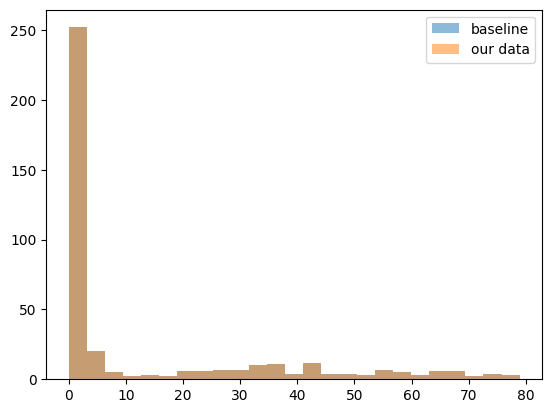

In [10]:
plt.hist(y, bins=25, alpha=0.5, label='baseline')
plt.hist(y_new, bins=25, alpha=0.5, label='our data')
plt.legend();

In [11]:
(np.sort(y) - np.sort(y_new)).sum()

0.0

They are identical. 

### Training and validation sets

In [12]:
target = "CaCO3%"
subset = "train"
info_df, validation_df, target_dir, spe_dir = read_files(target, subset)

       dirname        core  mid_depth_mm
0     1642.csv  PS75-093-1        7505.0
1     1306.csv  PS75-054-1        3405.0
2     1305.csv  PS75-054-1        3305.0
3     1512.csv  PS75-083-1        1705.0
4      616.csv  PS97-080-1         505.0
...        ...         ...           ...
1483  1425.csv  PS75-054-1       15305.0
1484   343.csv  SO264-13-2         125.0
1485   192.csv  SO264-55-1        4645.0
1486   899.csv  PS97-085-3       12005.0
1487   418.csv  LV29-114-3        2205.0

[1488 rows x 3 columns]


In [13]:
# use the baseline codes to subset data
prepare = nwp_cali.PrepareData(
    measurement=target, 
    data_dir=f"{cwd}/data/legacy/spe+bulk_dataset_20220629.csv", 
    select_dir=f"{cwd}/data/legacy/ML station list.xlsx")

# note: its select_data()
data_df = prepare.select_data()
X, y = prepare.produce_Xy(data_df)

In [14]:
print(f"data amount in annotation file: {len(info_df)+len(validation_df)}")
print(f"actual data amount: {len(target_dir)}")
print(f"actual spe amount: {len(spe_dir)}")
print(f"cores: {info_df.core.unique()}")

print(f"data amount using baseline codes: {len(y)}")

data amount in annotation file: 1860
actual data amount: 1860
actual spe amount: 1860
cores: ['PS75-093-1' 'PS75-054-1' 'PS75-083-1' 'PS97-080-1' 'SO264-28-2'
 'PS97-093-2' 'PS97-079-2' 'SO264-55-1' 'SO264-56-2' 'PS75-095-5'
 'PS97-084-1' 'PS97-085-3' 'PS97-078-1' 'SO264-64-1' 'LV29-114-3'
 'PS97-092-1' 'SO264-15-2' 'PS97-083-2' 'PS97-089-1' 'PS97-052-4'
 'SO264-13-2' 'SO264-66-2' 'PS97-053-2' 'PS97-046-4' 'PS97-027-2'
 'PS97-128-2']
data amount using baseline codes: 1860


The data amounts in the annotation file, actual target folder, actual spe folder and the extration by the baseline codes are all the same.

Let's check if the data are identical.

In [15]:
y_train_new = []
y_val_new = []

for csv in info_df.dirname:
    measurement = np.loadtxt(f"{cwd}/data/finetune/{target}/{subset}/target/{csv}", delimiter=",", dtype=float)
    y_train_new.append(measurement)

for csv in validation_df.dirname:
    measurement = np.loadtxt(f"{cwd}/data/finetune/{target}/{subset}/target/{csv}", delimiter=",", dtype=float)
    y_val_new.append(measurement)

y_train_new = np.array(y_train_new)
y_val_new = np.array(y_val_new)

In [16]:
from sklearn.model_selection import train_test_split
y_train, y_val = train_test_split(y, test_size = 0.2, shuffle = True, random_state = 24)


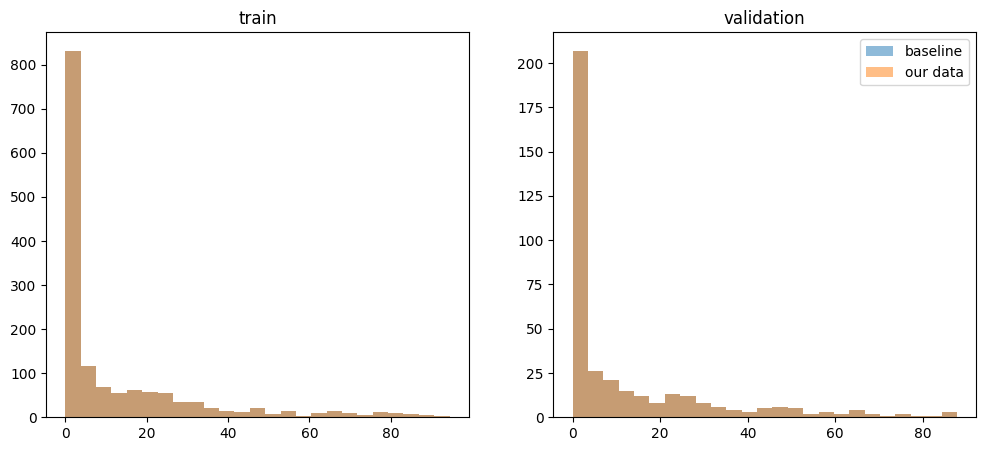

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].set_title("train")
axes[0].hist(y_train, bins=25, alpha=0.5, label='baseline')
axes[0].hist(y_train_new, bins=25, alpha=0.5, label='our data')

axes[1].set_title("validation")
axes[1].hist(y_val, bins=25, alpha=0.5, label='baseline')
axes[1].hist(y_val_new, bins=25, alpha=0.5, label='our data')
plt.legend();

In [18]:
print((np.sort(y_train) - np.sort(y_train_new)).sum())
print((np.sort(y_val) - np.sort(y_val_new)).sum())

0.0
0.0


They are identical.

## TOC
### Test set

In [20]:
target = "TOC%"
subset = "test"
info_df, target_dir, spe_dir = read_files(target, subset)

     dirname         core  mid_depth_mm
0      0.csv   PS75-056-1          15.0
1      1.csv   PS75-056-1          55.0
2      2.csv   PS75-056-1         155.0
3      3.csv   PS75-056-1         255.0
4      4.csv   PS75-056-1         355.0
..       ...          ...           ...
391  391.csv  LV28-44-3-n       10875.0
392  392.csv  LV28-44-3-n       10925.0
393  393.csv  LV28-44-3-n       10975.0
394  394.csv  LV28-44-3-n       11025.0
395  395.csv  LV28-44-3-n       11075.0

[396 rows x 3 columns]


In [21]:
# use the baseline codes to subset data
test_cores = ["PS75-056-1", "LV28-44-3-n", "SO264-69-2"]
prepare = nwp_cali.PrepareData(
    measurement=target, 
    data_dir=f"{cwd}/data/legacy/spe+bulk_dataset_20220629.csv", 
    select_dir=f"{cwd}/data/legacy/ML station list.xlsx")

# note: its select_casestudy()
data_df = prepare.select_casestudy(case_cores = test_cores)
X, y = prepare.produce_Xy(data_df)

In [22]:
print(f"data amount in annotation file: {len(info_df)}")
print(f"actual data amount: {len(target_dir)}")
print(f"actual spe amount: {len(spe_dir)}")
print(f"cores: {info_df.core.unique()}")

print(f"data amount using baseline codes: {len(y)}")

data amount in annotation file: 396
actual data amount: 396
actual spe amount: 396
cores: ['PS75-056-1' 'SO264-69-2' 'LV28-44-3-n']
data amount using baseline codes: 396


The data amounts in the annotation file, actual target folder, actual spe folder and the extration by the baseline codes are all the same.

Let's check if the data are identical.

In [23]:
y_new = []

for csv in info_df.dirname:
    measurement = np.loadtxt(f"{cwd}/data/finetune/{target}/{subset}/target/{csv}", delimiter=",", dtype=float)
    y_new.append(measurement)

y_new = np.array(y)

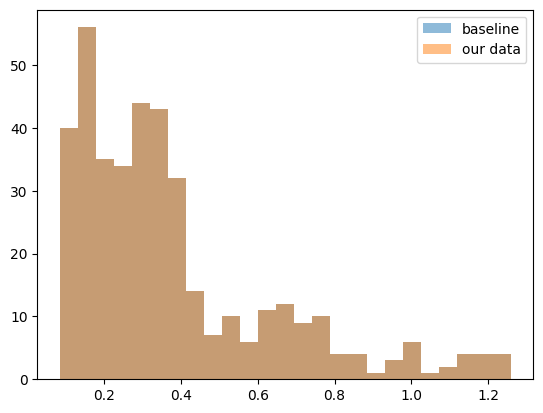

In [24]:
plt.hist(y, bins=25, alpha=0.5, label='baseline')
plt.hist(y_new, bins=25, alpha=0.5, label='our data')
plt.legend();

In [25]:
(np.sort(y) - np.sort(y_new)).sum()

0.0

They are identical.

### Training and validation sets

In [27]:
target = "TOC%"
subset = "train"
info_df, validation_df, target_dir, spe_dir = read_files(target, subset)

       dirname        core  mid_depth_mm
0      102.csv  SO264-56-2        8555.0
1      928.csv  PS97-085-3       11705.0
2     1570.csv  PS75-083-1        3705.0
3      861.csv  PS97-085-3        5005.0
4     1158.csv  PS97-093-2        2805.0
...        ...         ...           ...
1568  1425.csv  PS75-054-1       11605.0
1569   343.csv  SO264-13-2         125.0
1570   192.csv  SO264-55-1        4645.0
1571   899.csv  PS97-085-3        8805.0
1572   418.csv  LV29-114-3        2205.0

[1573 rows x 3 columns]


In [28]:
# use the baseline codes to subset data
prepare = nwp_cali.PrepareData(
    measurement=target, 
    data_dir=f"{cwd}/data/legacy/spe+bulk_dataset_20220629.csv", 
    select_dir=f"{cwd}/data/legacy/ML station list.xlsx")

# note: its select_data()
data_df = prepare.select_data()
X, y = prepare.produce_Xy(data_df)

In [29]:
print(f"data amount in annotation file: {len(info_df)+len(validation_df)}")
print(f"actual data amount: {len(target_dir)}")
print(f"actual spe amount: {len(spe_dir)}")
print(f"cores: {info_df.core.unique()}")

print(f"data amount using baseline codes: {len(y)}")

data amount in annotation file: 1967
actual data amount: 1967
actual spe amount: 1967
cores: ['SO264-56-2' 'PS97-085-3' 'PS75-083-1' 'PS97-093-2' 'PS75-093-1'
 'SO178-12-3' 'PS75-095-5' 'PS75-054-1' 'LV29-114-3' 'PS97-092-1'
 'SO264-66-2' 'PS97-079-2' 'SO264-28-2' 'PS97-089-1' 'PS97-027-2'
 'PS97-052-4' 'SO264-55-1' 'PS97-053-2' 'PS97-084-1' 'SO264-13-2'
 'SO264-15-2' 'PS97-083-2' 'SO264-64-1' 'PS97-078-1' 'PS97-128-2'
 'PS97-080-1' 'PS97-046-4']
data amount using baseline codes: 1967


The data amounts in the annotation file, actual target folder, actual spe folder and the extration by the baseline codes are all the same.

Let's check if the data are identical.

In [30]:
y_train_new = []
y_val_new = []

for csv in info_df.dirname:
    measurement = np.loadtxt(f"{cwd}/data/finetune/{target}/{subset}/target/{csv}", delimiter=",", dtype=float)
    y_train_new.append(measurement)

for csv in validation_df.dirname:
    measurement = np.loadtxt(f"{cwd}/data/finetune/{target}/{subset}/target/{csv}", delimiter=",", dtype=float)
    y_val_new.append(measurement)

y_train_new = np.array(y_train_new)
y_val_new = np.array(y_val_new)

In [31]:
from sklearn.model_selection import train_test_split
y_train, y_val = train_test_split(y, test_size = 0.2, shuffle = True, random_state = 24)


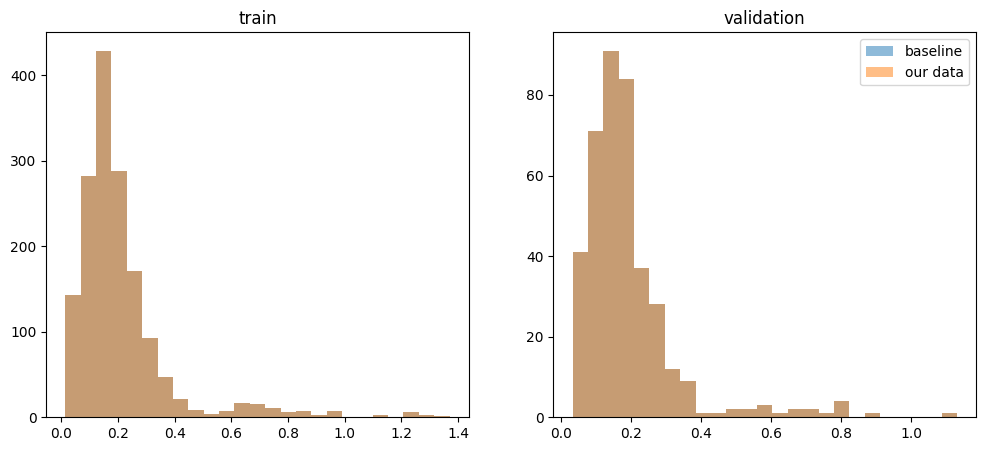

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].set_title("train")
axes[0].hist(y_train, bins=25, alpha=0.5, label='baseline')
axes[0].hist(y_train_new, bins=25, alpha=0.5, label='our data')

axes[1].set_title("validation")
axes[1].hist(y_val, bins=25, alpha=0.5, label='baseline')
axes[1].hist(y_val_new, bins=25, alpha=0.5, label='our data')
plt.legend();

In [33]:
print((np.sort(y_train) - np.sort(y_train_new)).sum())
print((np.sort(y_val) - np.sort(y_val_new)).sum())

0.0
0.0


They are identical.

# Conclusion
The finetune data (training, validation, test) are all identical to the data using the baseline codes to split. The XRF spectra don't need to be compare to the baseline because the baseline doesn't have this pre-train process. But we robustly keep the test set cores same as in the finetune data to avoid any data-snooping issue. 

# Visualize the data distributions

In [42]:
info_dict = {}
y_dict = {}
for target in ["CaCO3%", "TOC%"]:
    info_dict["test"], _, _ = read_files(target, "test")
    info_dict["train"], info_dict["val"], _, _ = read_files(target, "train")

    y_dict[target] = {}
    for subset in ["test", "train", "val"]:
        y = []
        if subset == "test":
            for csv in info_dict[subset].dirname:
                measurement = np.loadtxt(f"{cwd}/data/finetune/{target}/test/target/{csv}", delimiter=",", dtype=float)
                y.append(measurement)
        else:
            # train and val read the spe from the same directory but based on the different info.csv
            for csv in info_dict[subset].dirname:
                measurement = np.loadtxt(f"{cwd}/data/finetune/{target}/train/target/{csv}", delimiter=",", dtype=float)
                y.append(measurement)

        y_dict[target][subset] = np.array(y)
    

     dirname         core  mid_depth_mm
0      0.csv   PS75-056-1          15.0
1      1.csv   PS75-056-1          55.0
2      2.csv   PS75-056-1         155.0
3      3.csv   PS75-056-1         255.0
4      4.csv   PS75-056-1         355.0
..       ...          ...           ...
389  389.csv  LV28-44-3-n       10875.0
390  390.csv  LV28-44-3-n       10925.0
391  391.csv  LV28-44-3-n       10975.0
392  392.csv  LV28-44-3-n       11025.0
393  393.csv  LV28-44-3-n       11075.0

[394 rows x 3 columns]
       dirname        core  mid_depth_mm
0     1642.csv  PS75-093-1        7505.0
1     1306.csv  PS75-054-1        3405.0
2     1305.csv  PS75-054-1        3305.0
3     1512.csv  PS75-083-1        1705.0
4      616.csv  PS97-080-1         505.0
...        ...         ...           ...
1483  1425.csv  PS75-054-1       15305.0
1484   343.csv  SO264-13-2         125.0
1485   192.csv  SO264-55-1        4645.0
1486   899.csv  PS97-085-3       12005.0
1487   418.csv  LV29-114-3        2205.0

[14

In [46]:
for target in ["CaCO3%", "TOC%"]:
    print(f"target: {target}")
    for subset in ["test", "train", "val"]:
        print(f"amount in {subset}: {len(y_dict[target][subset])}")

target: CaCO3%
amount in test: 394
amount in train: 1488
amount in val: 372
target: TOC%
amount in test: 396
amount in train: 1573
amount in val: 394


20240716


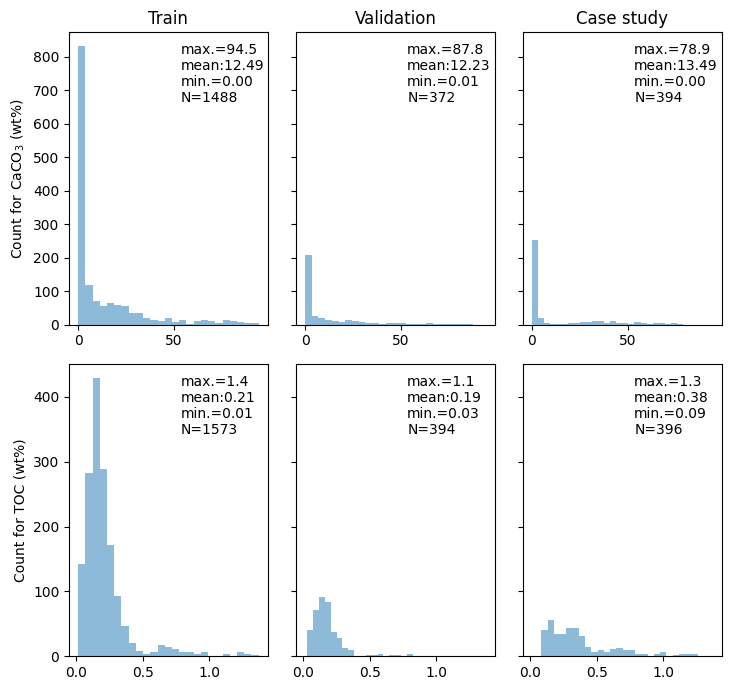

In [68]:
fig, axes = plt.subplots(2, 3, sharex='row', sharey='row', figsize=(7.5, 7))

for i, target in enumerate(["CaCO3%", "TOC%"]):
    for j, subset in enumerate(["train", "val", "test"]):
        y = y_dict[target][subset]
        axes[i, j].hist(y, bins=25, alpha=0.5)

        axes[i, j].text(0.56, 0.76, "max.={:.1f}\nmean:{:.2f}\nmin.={:.2f}\nN={}".format(
            y.max(), y.mean(), y.min(), len(y)), transform=axes[i, j].transAxes)


    #axes[i, j].set_xlabel('wt%\n{}'.format(target))
# The test set is named as case study after discussion
for j, subset in enumerate(["Train", "Validation", "Case study"]):
    axes[0, j].set_title(subset)

axes[0, 0].set_ylabel("Count for CaCO$_3$ (wt%)")
axes[1, 0].set_ylabel("Count for TOC (wt%)")


#fig.subplots_adjust(wspace=.05, top=.92)
fig.tight_layout()
fig.savefig('files/data_hist_{}.png'.format(date))
print(date)